In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
data=pd.read_csv('C:/Users/KIMYEONKYOUNG/Desktop/code/jena_climate_2009_2016.csv/jena_climate_2009_2016.csv')

In [3]:
data

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


데이터는 10분마다 기록됨. 한시간 동안 6개, 하루에 144개의 관측치가 포함됨.  앞으로 6시간의 온도를 예측 (예측하기 위해 5일간의 온도 데이터를 사용)
모형을 학습하기 위해 720(5*144)개의 관측값이 포함된 window를 만듬

In [4]:
# TRAIN_SPLIT=3000000
# tf.random.set_seed(13)

In [5]:
# uni_data=data['T (degC)']
# uni_data.index=data['Date Time']
# uni_data.head()       

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

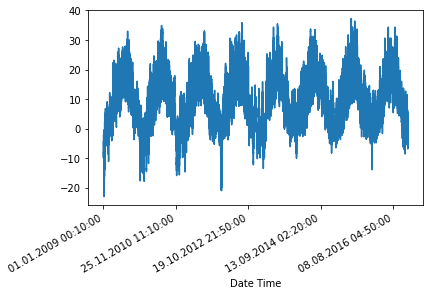

In [6]:
# 시간에 따른 온도 편차 그래프
uni_data.plot(subplots=True)

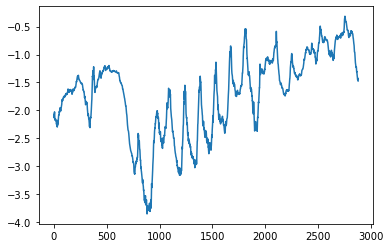

In [24]:
#처음 20일간 온도 그래프 그리기
plt.plot(range(144*20), uni_data[:144*20])

In [45]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [46]:
# 코드 6-34 후련, 검증, 테스트 제너레이터 준비하기
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(uni_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(uni_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(uni_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [48]:
# 코드 6-35 상식적인 기준 모델의 MAE 계산하기

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

MemoryError: Unable to allocate 96.3 GiB for an array with shape (128, 240, 420551) and data type float64

In [ ]:
# 코드 6-36 MAE 섭씨 단위로 변환하기

0.29 * std[1]

In [38]:
# 데이터 파싱하기
float_data = np.zeros((data.shape[0], data.shape[1]))
for i in range(0,data.shape[0]-1) :#enumerate(data.shape[0]):
  values = [float(x) for x in data.shape[0].split(',')[1:]]
  float_data[i,:] = values

AttributeError: 'int' object has no attribute 'split'

In [12]:
#온도 데이터(Y) 표준화
# uni_data=uni_data.values
uni_train_mean=uni_data[:TRAIN_SPLIT].mean()
uni_train_std=uni_data[:TRAIN_SPLIT].std()
uni_data=(uni_data-uni_train_mean)/uni_train_std

In [19]:
def univariate_data(dataset,start_index,end_index,history_size,target_size):
    data = []
    labels = []
    
    start_index=start_index + history_size #history_size:과거 information window의 크기(몇 개의 과거 데이터를 학습할 것인지)  #20
    if end_index is None :
        end_index=len(dataset) - target_size #target_size 예측해야하는 레이블
        
    for i in range(start_index,end_index):
        indices=range(i-history_size,i) #얘가 오류를 발생시킴
#         print(indices)
        # reshape data from(history_size,) to (history_size,1)
        data.append(np.reshape(dataset[indices],(history_size,1)))
        labels.append(dataset[i]+target_size)
    return np.array(dataset),np.array(labels)#print(start_index,end_index,indices)
    

In [20]:
univariate_past_history=20
univariate_future_target=0

x_train_uni,y_train_uni=univariate_data(uni_data,0,TRAIN_SPLIT,univariate_past_history,univariate_future_target) #
# x_val_uni,y_val_uni=univariate_data(uni_data,TRAIN_SPLIT,None,univariate_past_history,univariate_future_target)

IndexError: index 420551 is out of bounds for axis 0 with size 420551

In [63]:

x_train_uni
